In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [107]:
sns.set(rc={'figure.figsize': (9, 6)})

### events_train.csv - данные о действиях, которые совершают студенты со стэпами
step_id - id стэпа
user_id - анонимизированный id юзера
timestamp - время наступления события в формате unix date
action - событие, возможные значения:
discovered - пользователь перешел на стэп
viewed - просмотр шага,
started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
passed - удачное решение практического шага
### submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям

step_id - id стэпа
timestamp - время отправки решения в формате unix date
submission_status - статус решения
user_id - анонимизированный id юзера

In [108]:
events_data = pd.read_csv('data/event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [109]:
submissions_data = pd.read_csv('data/submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [110]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
submissions_data['day'] = submissions_data.date.dt.date

In [111]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [112]:
users_scores = submissions_data.pivot_table(
    index='user_id',
    columns='submission_status',
    values='step_id',
    aggfunc='count',
    fill_value=0).reset_index()

In [113]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [114]:
# попробуем определить какие пользователи бросили курс, а какие нет
# для этого посмотрим распределение решений у пользователей
# 1) Удалим дублирующиеся значения user_id и day одновременно чтобы оставить по одной записи захода пользователя в день.
# 2) Сгрупируем по user_id выберем поле timestamp применим к нему list по apply получив списки всех timestamp ползователя
# 3) Применим к значениям получившегося списка np.diff которая считает разность между ближайшими наблюдениями
gap_data = events_data[['user_id', 'day', 'timestamp']]\
    .drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

In [115]:
# Пример использования drop_duplicates()
events_data[['step_id', 'user_id']].head()

,step_id,user_id
0,32815,17632
1,32815,17632
2,32815,17632
3,32811,17632
4,32811,17632


In [116]:
events_data[['step_id', 'user_id']].head().drop_duplicates()

,step_id,user_id
0,32815,17632
3,32811,17632


In [117]:
# совместим данные в один массив
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [118]:
gap_data = gap_data / (24 * 60 * 60) # Разница в днях между заходами на курс

<AxesSubplot:>

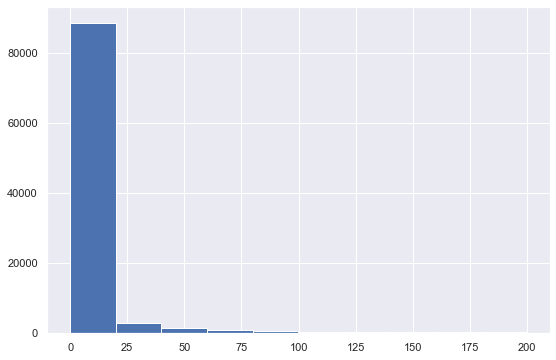

In [119]:
gap_data[gap_data < 200].hist() # Уменьшим чтобы исключить большие выборсы
# Получается что большая часть gap-ов разрывов по заходам составляет от нуля до 25-и дней.

In [120]:
gap_data.quantile(0.95)
# Только пять процентов пользователей возвращается на курс с перерывом почти 2 месяца (59 дней)

59.760440972222156

# Разметим являются ли пользователь покинувшим курс или нет

In [121]:
# Условие будет что человек не получил сертификат о прохождении курса и не появляется 30 дней на платформе.
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [122]:
# Посмотрим максимальный timestamp для пользователя
users_data = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'max'})\
    .rename(columns={'timestamp': 'last_timestamp'}).head()

In [123]:
now = 1521634660 # последний день.
drop_out_threshold = 2592000 # (24 * 60 * 60) * 30 или 30 дней

In [124]:
# Сделаем столбец показывающий если разница между последнем timestamp вообще и последним заходом пользователя на платформу
# больше 30 дней (drop_out_threshold - порог покидания, ухода)
# или другими словами пользователи отстутствующие на платформе больше 30 дней пометим true
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [125]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,False
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,False


# Добавим данные про количество правильных и не правильных submission

In [126]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

In [127]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [128]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [129]:
users_data = users_data.fillna(0)

In [130]:
users_data.last_timestamp = users_data.last_timestamp.astype('int64')

In [131]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,False,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,False,0.0,0.0


In [132]:
# Строили таким образом гистограмму в 1_10 модуле:
# Подсчет событий для каждого пользователя:
users_events_data = events_data.pivot_table(
    index='user_id',
    columns='action',
    values='step_id',
    aggfunc='count',
    fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [133]:
users_data = users_data\
    .merge(users_events_data, how='outer')\
    .fillna(0)
users_data.last_timestamp = users_data.last_timestamp.astype('int64')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,False,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,False,0.0,0.0,1,1,0,1


In [137]:
# Нужно еще добавить сколько уникальных дней пользователь был на платформе.
# to_frame преобразует из серии в DataFrame
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [138]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [139]:
users_data = users_data.merge(users_days, how='outer')
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [140]:
# Убеждаемся что никого не потеряли
users_data.user_id.nunique()

19234

In [141]:
events_data.user_id.nunique()

19234

In [146]:
# Нужно добавить прошел ли успешно человек курс. Мы имперически возьмем условие: если он прошел 175 шагов навпример.
users_data['passed_course'] = users_data.passed > 170

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,False,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,False,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26773,0,0,0.0,0.0,1,1,0,1,1,False
19230,26774,0,0,0.0,0.0,1,1,0,1,1,False
19231,26788,0,0,0.0,0.0,1,1,0,1,1,False
19232,26789,0,0,0.0,0.0,2,2,0,2,1,False


In [147]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,False
1,2,1519226966,False,2.0,0.0,9,9,2,10,2,False,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,False
4,7,1521634660,False,0.0,0.0,1,1,0,1,1,False,False


In [148]:
# Можем посмотреть сколько прошло курс, а сколько нет
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
passed_course,,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [149]:
# Данные соответствую стандарту индустрии по прохождению курса
100* 1425 / 17809

8.001572238755685

# Итоги проделанной работы
- Получили сырые данные из разных источников.
- Проверили данные на валидность, на очевидную непротиворечивость.
- Перевели в агрегированную таблицу данные.
- Извелекли новые фичи.